<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [483]:
%%capture
pip install pyswarms

In [484]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [485]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'

In [486]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [487]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [488]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [489]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [490]:
 # Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)
    return fator

In [491]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [492]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [493]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [494]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [495]:
# Leitura dos dados de tempo: exemplo tese Marcos Coque Jr.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/data.csv', sep=";")
df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


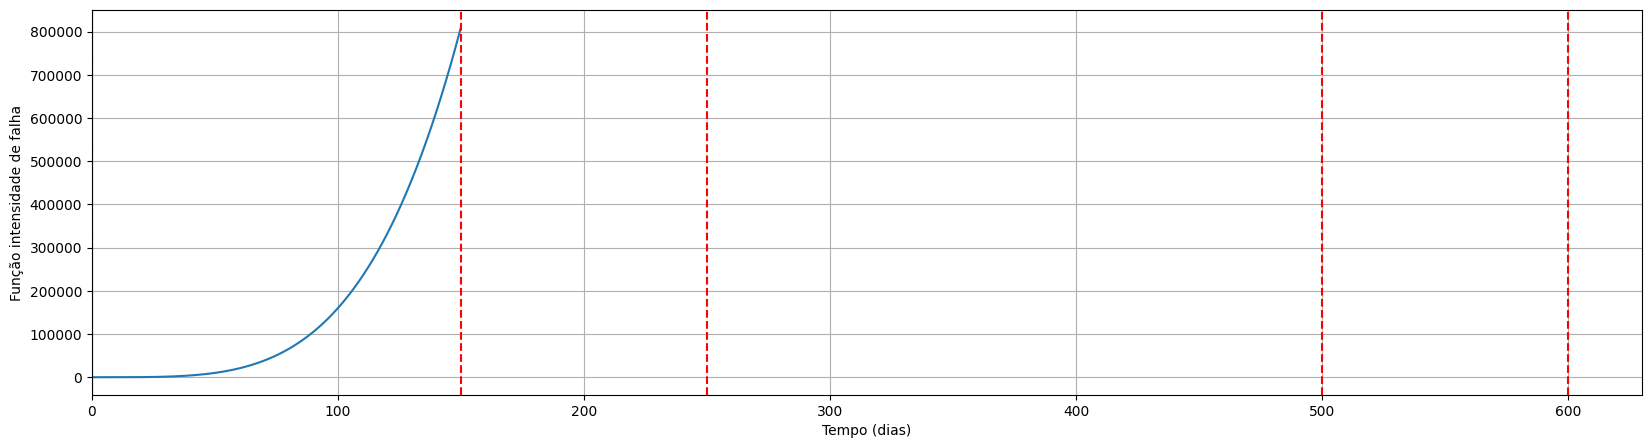

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [496]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [501]:
def objective_st(x):
    # Dicionario para severidades
    dict_severidades = {1:0.25, 3:0.50, 5:0.75, 7:1.0}

    # Criação de variáveis para os parâmetros
    lamb = x[0]
    beta = x[1]
    theta = x[2]

    t = df['t']
    k = df['k']
    m = df['k'].nunique()
    ck = df['c'].max()
    n = []
    s = []

    if ck == 0:
        return MAX_VALUE_CUSTO

    num_ciclos = ck

    for k in range(m):
        n.append(list(df['n'][k * ck:(k + 1) * ck]))
        s_row = []
        for j in range(num_ciclos):
            s_row.append(df['s'][k * ck + j])
        s.append(s_row)

   # Obter os tempos para manutenções preventivas
    T = list(df['T'][:m])
    tempos_mp = T[1:]

    beta = 5

    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    termos_somatorio = [((1 / (lamb ** beta)) * (T[1] ** beta))]
    numero_medio_falhas = [0, ((1 / (lamb ** beta)) * (T[1] ** beta))]

    for i in range(ck - 1):
        termo = (((T[i + 2] - fator[i] * T[i + 1]) ** beta) - (((1 - fator[i]) * T[i + 1]) ** beta)) * (1 / (lamb ** beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    final = 730
    termo = (((final - fator[ck - 1] * T[ck]) ** beta) - (((1 - fator[ck - 1]) * T[ck]) ** beta)) * (1 / (lamb ** beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    Ctotal = []
    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i + 1] - mi[i]) * CMC) / (T[i + 1] - T[i]))

    cmp = custo_mp(s[0][ck - 1], CMP)
    Ctotal.append((cmp + (mi[ck + 1] - mi[ck]) * CMC) / (final - T[ck]))

    Custo = np.sum(Ctotal)

    # Formatar o valor do custo
    Custo_formatado = format(Custo, '.2f')
    Custo_formatado = Custo_formatado.replace('.', '').replace(',', '.')

    print("")
    print("=========================================================================")
    print("")

     # Imprimir o custo total para manutenções preventivas
    print("Custo Total:", Custo_formatado)

     # Imprimir o número de ciclos de manutenção
    print("Número de Ciclos de Manutenção:", num_ciclos)

    # Imprimir os tempos para manutenções preventivas
    print("Tempos para Manutenções Preventivas:", tempos_mp)

    # Imprimir os tempos para manutenções preventivas
    print("Número de Sisemas:", m)

    # Imprimir a severidade para cada ciclo de manutenção
    print("=========================================================================")
    print("")
    for k in range(m):
        for i in range(num_ciclos):
            if not np.isnan(s[k][i]):
                print("Severidade para Ciclo de Manutenção", i+1, "do Sistema", k+1, ":", s[k][i])

    return Custo

In [502]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-07-06 19:14:49,388 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   3%|▎         |3/100, best_cost=2.19e+20



Custo Total: 14115231021371091425689600
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 

pyswarms.single.global_best:   6%|▌         |6/100, best_cost=5.25e+19

Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Custo Total: 5251941310661688524800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do S

pyswarms.single.global_best:   9%|▉         |9/100, best_cost=5.25e+19



Custo Total: 15071172617355123097600
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best:  13%|█▎        |13/100, best_cost=5.25e+19



Custo Total: 10706397372634415104000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best:  20%|██        |20/100, best_cost=5.25e+19



Custo Total: 8959472608367468544000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do S

pyswarms.single.global_best:  24%|██▍       |24/100, best_cost=5.25e+19

3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Custo To

pyswarms.single.global_best:  31%|███       |31/100, best_cost=5.25e+19

 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Custo Total: 12413448634559984435200
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutençã

pyswarms.single.global_best:  35%|███▌      |35/100, best_cost=5.25e+19



Custo Total: 7319536052904371814400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do S

pyswarms.single.global_best:  38%|███▊      |38/100, best_cost=5.25e+19



Custo Total: 14257969413682798592000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best:  42%|████▏     |42/100, best_cost=5.25e+19

0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Custo Total: 11198713880975784345600
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3

pyswarms.single.global_best:  49%|████▉     |49/100, best_cost=5.25e+19

 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Custo Total: 12157271865570104115200
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
N

pyswarms.single.global_best:  53%|█████▎    |53/100, best_cost=3.74e+19



Custo Total: 4640517316184571904000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do S

pyswarms.single.global_best:  61%|██████    |61/100, best_cost=2.71e+19

 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Custo Total: 55585596836035146547200
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Cic

pyswarms.single.global_best:  64%|██████▍   |64/100, best_cost=2.71e+19



Custo Total: 3365022678661500108800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do S

pyswarms.single.global_best:  72%|███████▏  |72/100, best_cost=2.71e+19

 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Custo Total: 17070403607561093120000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manuten

pyswarms.single.global_best:  75%|███████▌  |75/100, best_cost=2.71e+19



Custo Total: 7220985924627346227200
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do S

pyswarms.single.global_best:  83%|████████▎ |83/100, best_cost=2.71e+19

 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Custo Total: 4201708917967131443200
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4

pyswarms.single.global_best:  86%|████████▌ |86/100, best_cost=2.65e+19



Custo Total: 18888713156817374412800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best:  94%|█████████▍|94/100, best_cost=2.36e+19

 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Custo Total: 2793211772338006425600
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Cicl

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=1.68e+19
2023-07-06 19:14:54,541 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.680143655849484e+19, best pos: [1.12500283 3.85144225 1.3104596  0.86972994 1.33373879 0.10021148
 4.32529777 2.27456277 1.17351913 3.09792796 0.56918405 2.54786229
 2.61106746 1.19248879 1.29840611 2.14112457 1.63704439 4.02471712
 2.26262551 1.96615206 2.94644949 0.96007399 4.43718966 1.78003744]
2023-07-06 19:14:54,543 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


Custo Total: 26256885804142480588800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 1252019977603316736000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:54,732 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12510615 3.86119805 1.31046182 0.86973045 1.33419384 0.10021346
 4.31730665 2.27440275 1.17423145 3.09699358 0.5691656  2.54718301
 2.6109956  1.19219525 1.29863897 2.14115164 1.63704303 4.02458237
 2.26262131 1.9661238  2.94716626 0.95992352 4.44073542 1.78018568]
2023-07-06 19:14:54,733 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:54,747 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12519914 3.86997826 1.31046382 0.8697309  1.33460338 0.10021524
 4.31011464 2.27425873 1.17487254 3.09615263 0.569149   2.54657166
 2.61093093 1.19193106 1.29884853 2.141176   1.6370418  4.0244611
 2.26261752 1.96609836 2.94781134 0.9597881  4.44392661 1.78031911]
2023-07-06 19:14:54,749 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 1353593558044492390400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do S

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:54,762 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.1252733  3.87687724 1.31046557 0.8697313  1.3348588  0.10021683
 4.30467917 2.27416427 1.17531328 3.0953988  0.56913825 2.54619495
 2.61088725 1.19172463 1.29899651 2.14119389 1.63704088 4.02437764
 2.26261505 1.96608053 2.94830257 0.95968811 4.44635255 1.7804005 ]
2023-07-06 19:14:54,764 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 2242100007960460902400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do S

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 5907954198146130739200
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do S

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:55,006 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12530849 3.88114866 1.31046651 0.86973162 1.33507752 0.10021755
 4.3013839  2.27413059 1.17553665 3.09472309 0.56912889 2.54585997
 2.61088027 1.1915458  1.29912238 2.14120521 1.63704032 4.02435126
 2.26261454 1.96606514 2.94848894 0.95960109 4.44750541 1.78046778]
2023-07-06 19:14:55,008 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:55,020 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12530912 3.87972965 1.31046611 0.86973169 1.33505839 0.10021799
 4.2985871  2.2741619  1.17536806 3.09433704 0.56912283 2.54588545
 2.6108748  1.19156889 1.29911697 2.14120925 1.63704007 4.02435111
 2.26261595 1.96605629 2.94865369 0.95959682 4.44739044 1.78046392]
2023-07-06 19:14:55,021 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 30697971124915640729600
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:55,032 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12525945 3.8768219  1.31046505 0.86973158 1.33483157 0.10021835
 4.29881674 2.27420565 1.17519851 3.09399405 0.56912967 2.5460037
 2.61089136 1.19161263 1.29910426 2.14120663 1.63704046 4.02441059
 2.26261846 1.96606777 2.94873211 0.95959719 4.44554258 1.7804441 ]
2023-07-06 19:14:55,034 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 251932957156270879539200
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:55,046 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.1251829  3.87106211 1.31046357 0.86973123 1.33454094 0.10021786
 4.30308223 2.27429851 1.17485401 3.09419606 0.56913642 2.54634403
 2.6109071  1.19171595 1.2990148  2.1411919  1.63704132 4.0244653
 2.26262117 1.96608    2.94864276 0.95961826 4.44302691 1.7803716 ]
2023-07-06 19:14:55,048 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 1403094513953179225292800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:55,180 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12509393 3.86378878 1.31046189 0.86973083 1.33418647 0.10021612
 4.30843078 2.2744077  1.17443062 3.09493443 0.56914312 2.54686773
 2.61092854 1.19183366 1.2988481  2.14117148 1.63704252 4.02451817
 2.26262364 1.96609432 2.94826291 0.95965555 4.44044438 1.7802886 ]
2023-07-06 19:14:55,182 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3212964407101998130790400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:55,197 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.1250153  3.85695095 1.31046036 0.86973039 1.33386956 0.10021415
 4.31508674 2.2745051  1.17399949 3.09604374 0.56915473 2.54741503
 2.61095215 1.19203214 1.29869389 2.14115043 1.63704373 4.02456694
 2.26262568 1.96611453 2.94775047 0.95974851 4.43815842 1.78021061]
2023-07-06 19:14:55,198 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 3002501309432231205273600
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:55,213 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12495859 3.8515853  1.31045939 0.86973001 1.33362029 0.10021233
 4.32114858 2.27457212 1.17365594 3.09729309 0.56916638 2.54784662
 2.61097879 1.19224695 1.29854351 2.14113169 1.63704477 4.02461546
 2.26262731 1.96613497 2.94714017 0.95985557 4.43641769 1.78013785]
2023-07-06 19:14:55,214 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 1402331899943513908838400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 d

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 472683038220099151462400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:55,510 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12494609 3.8470867  1.31045896 0.86972974 1.33350787 0.1002109
 4.32639194 2.27461434 1.17335925 3.0983778  0.56917672 2.5480778
 2.61100776 1.19243781 1.29842093 2.14112005 1.63704544 4.02465774
 2.26262734 1.9661501  2.94659706 0.9599709  4.43612641 1.78008401]
2023-07-06 19:14:55,598 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:55,715 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.1249487  3.84508    1.31045877 0.86972953 1.33349248 0.1002102
 4.32892005 2.27462328 1.17326102 3.09910116 0.56918601 2.54813924
 2.61103316 1.19258145 1.29832141 2.14111688 1.63704576 4.02469163
 2.26262655 1.96616305 2.94625671 0.9600676  4.43640129 1.78003951]
2023-07-06 19:14:55,719 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 169023527231631235481600
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:55,736 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12497589 3.84426793 1.31045891 0.86972945 1.33349166 0.10020993
 4.3292671  2.27459338 1.17334475 3.09948584 0.56919363 2.54809598
 2.61105433 1.19269532 1.29824374 2.14112239 1.63704566 4.02469124
 2.26262535 1.96616498 2.94610172 0.96012035 4.43723461 1.78003969]
2023-07-06 19:14:55,737 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 53773079671348035584000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:55,759 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12501026 3.8483879  1.31045964 0.86972967 1.33368942 0.1002103
 4.32755052 2.27452822 1.17345214 3.09912538 0.56919583 2.54789387
 2.61106642 1.19276039 1.29819149 2.14113331 1.63704523 4.02468203
 2.26262367 1.96615973 2.94600855 0.96013376 4.43839801 1.78006001]
2023-07-06 19:14:55,764 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 21854656150618180812800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:55,779 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12506292 3.85522648 1.31046079 0.86973002 1.33388346 0.10021129
 4.3251042  2.27443439 1.17373782 3.09879846 0.56918998 2.54766936
 2.6110634  1.19272865 1.2982505  2.14114338 1.63704442 4.02465275
 2.26262198 1.96615484 2.94613158 0.96009237 4.43958144 1.78008829]
2023-07-06 19:14:55,780 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 12325154648922339737600
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:55,801 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12512062 3.86217463 1.31046199 0.86973036 1.33407659 0.10021275
 4.32214609 2.27434703 1.17407486 3.09827823 0.56918334 2.54735588
 2.61104616 1.19269995 1.29841047 2.14115367 1.63704339 4.02461745
 2.26262042 1.9661491  2.94638266 0.96004308 4.44076689 1.78013978]
2023-07-06 19:14:55,802 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 9053705193357053132800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do S

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:55,821 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12517217 3.86834347 1.31046304 0.86973068 1.33428167 0.10021425
 4.31883841 2.27428123 1.17440639 3.09780558 0.56917357 2.54705672
 2.61102413 1.19266978 1.29860949 2.14116266 1.63704247 4.02457808
 2.2626191  1.96614393 2.94667071 0.95998957 4.44182633 1.78019413]
2023-07-06 19:14:55,823 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 8126570688947770163200
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do S

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 8755824868526804172800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:56,000 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12520945 3.8731346  1.31046367 0.86973093 1.33445916 0.10021549
 4.31565982 2.27425413 1.17467208 3.09728672 0.56916258 2.54679961
 2.61099797 1.19256371 1.29878951 2.14117044 1.63704169 4.02454384
 2.26261803 1.96613899 2.94693679 0.95992659 4.44248303 1.78024241]
2023-07-06 19:14:56,001 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:56,015 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12522031 3.87678545 1.3104637  0.86973102 1.33455177 0.10021604
 4.31283384 2.27426565 1.17489153 3.09677863 0.56915346 2.54667165
 2.61097425 1.19244544 1.29893726 2.14117194 1.63704134 4.02451705
 2.26261773 1.96613164 2.94723846 0.95986959 4.44297962 1.78027356]
2023-07-06 19:14:56,016 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 13398770096034571878400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:56,033 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12522685 3.87984191 1.31046341 0.86973097 1.3346327  0.1002161
 4.31117708 2.27429164 1.17492894 3.09633724 0.56914797 2.5467028
 2.61095828 1.19227153 1.299032   2.14117166 1.63704151 4.02449936
 2.26261852 1.96612278 2.94749708 0.95982781 4.44336584 1.7802944 ]
2023-07-06 19:14:56,035 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 24482231732159935283200
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 49807711725302762700800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:56,215 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12522899 3.88163677 1.31046299 0.86973085 1.33457731 0.10021604
 4.30994366 2.27433295 1.17483284 3.09606992 0.56914574 2.54685205
 2.61094954 1.19209371 1.29900203 2.14116658 1.63704168 4.02450263
 2.2626197  1.9661149  2.94763143 0.95979261 4.44367793 1.78028731]
2023-07-06 19:14:56,216 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:56,230 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12522948 3.88060722 1.3104623  0.86973074 1.33450453 0.10021566
 4.31060127 2.27437756 1.1746825  3.09610291 0.56914402 2.54704313
 2.61094374 1.19195371 1.29890774 2.14115897 1.63704199 4.02451419
 2.26262091 1.96610794 2.94773578 0.95976584 4.44355601 1.78025638]
2023-07-06 19:14:56,231 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 100666283266857893888000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:56,250 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12521216 3.87621428 1.31046163 0.86973059 1.33442357 0.10021508
 4.31194488 2.2744212  1.17447319 3.09613526 0.56914742 2.54722495
 2.61093917 1.19187671 1.29879078 2.14115009 1.63704239 4.02452514
 2.26262212 1.9661028  2.94773299 0.95975741 4.44331395 1.78021789]
2023-07-06 19:14:56,252 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 198203923595915978342400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:56,265 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12518672 3.87210241 1.31046105 0.86973045 1.33428251 0.10021422
 4.31435333 2.27445639 1.1742361  3.0963036  0.5691537  2.54738208
 2.61094257 1.19188629 1.29865255 2.1411424  1.63704288 4.02454482
 2.262623   1.9661004  2.94767085 0.95977481 4.44258353 1.78017439]




Custo Total: 350296526979036086272000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do

2023-07-06 19:14:56,266 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Custo Total: 428440685791516767027200
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:56,442 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12514207 3.86793758 1.31046075 0.86973032 1.33414353 0.10021323
 4.31730892 2.2744783  1.17402253 3.0965785  0.56916026 2.54747616
 2.61095572 1.19198035 1.29852718 2.14113824 1.63704334 4.02457165
 2.26262379 1.9660995  2.94753743 0.95980276 4.44186915 1.78013666]
2023-07-06 19:14:56,443 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:56,455 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12509879 3.86248089 1.31046079 0.86973022 1.33402959 0.10021235
 4.31996855 2.27448364 1.1738565  3.09689271 0.56916658 2.54748416
 2.61097337 1.19206916 1.29842919 2.14113848 1.63704367 4.02459727
 2.2626243  1.96609971 2.94737118 0.95983562 4.44109029 1.78011488]
2023-07-06 19:14:56,457 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 289136473935698984960000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:56,470 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12506089 3.85748325 1.31046083 0.86973018 1.33396615 0.10021183
 4.32161738 2.27446732 1.17375281 3.09719273 0.56917219 2.54748286
 2.6109929  1.1921659  1.29838501 2.14114068 1.63704385 4.02461631
 2.26262413 1.966107   2.94716405 0.95986838 4.44031257 1.78011485]
2023-07-06 19:14:56,472 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 118138676156179467468800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 47594033220786559385600
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:56,660 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12503089 3.85306214 1.31046087 0.86973015 1.33394684 0.1002115
 4.32256433 2.27444333 1.17379291 3.09745122 0.56917667 2.54739718
 2.61101106 1.1922549  1.29841214 2.14114273 1.63704387 4.02462723
 2.26262384 1.96611761 2.94697809 0.95989876 4.43963564 1.78011611]
2023-07-06 19:14:56,661 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:56,676 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12501128 3.85069879 1.310461   0.86973018 1.3340015  0.10021157
 4.32216914 2.27441529 1.17392761 3.09761602 0.56917923 2.54729321
 2.61102562 1.19232365 1.29847502 2.14114706 1.63704374 4.02463426
 2.26262348 1.96612809 2.94682359 0.95993272 4.43932841 1.78013056]
2023-07-06 19:14:56,678 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 23101475002412007424000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:56,690 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12501807 3.84886287 1.31046132 0.86973021 1.33408886 0.10021191
 4.32054361 2.2743869  1.17411724 3.09760958 0.56917809 2.54719745
 2.61103402 1.1923648  1.29854081 2.14115105 1.63704353 4.02462667
 2.2626231  1.96613697 2.94678653 0.9599625  4.43931251 1.78014625]




Custo Total: 13339418801586080972800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

2023-07-06 19:14:56,691 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:56,705 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12502573 3.84956698 1.31046175 0.86973031 1.33419112 0.10021241
 4.31879713 2.27436366 1.17429738 3.09749955 0.56917483 2.54711055
 2.61103314 1.19238407 1.29862441 2.14115475 1.63704332 4.02460913
 2.26262273 1.96614123 2.94681339 0.95998481 4.4395126  1.78016079]
2023-07-06 19:14:56,707 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 9907761207850305126400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do S

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 11097129375897429606400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:56,880 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12503558 3.85283987 1.31046215 0.86973039 1.33428351 0.10021306
 4.31700887 2.2743522  1.17444012 3.09733294 0.56917004 2.54704605
 2.61102346 1.19239418 1.29870125 2.14115786 1.63704305 4.02458712
 2.26262205 1.9661401  2.94685668 0.95999487 4.44002212 1.7801771 ]
2023-07-06 19:14:56,881 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidad

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:56,896 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12504733 3.85828796 1.31046245 0.86973047 1.33436447 0.10021375
 4.31545698 2.27434834 1.17453101 3.09712758 0.56916539 2.54701778
 2.61101143 1.19235513 1.29875891 2.14115996 1.6370428  4.02456661
 2.26262126 1.96613801 2.94697687 0.95998823 4.44050927 1.78019435]
2023-07-06 19:14:56,897 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 16581876523208818688000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:56,910 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12506391 3.86351495 1.31046255 0.86973054 1.33439128 0.10021432
 4.31447468 2.27435922 1.17458832 3.09693311 0.56916123 2.54700244
 2.61099746 1.1922812  1.29880487 2.14116015 1.63704262 4.02455034
 2.26262056 1.96613209 2.9470966  0.95996481 4.44100477 1.78020788]
2023-07-06 19:14:56,911 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 29421793061458116608000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 53544662059958029516800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:57,089 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12508809 3.86766284 1.31046246 0.86973057 1.33439891 0.10021472
 4.31426033 2.27437716 1.17463121 3.09677405 0.56915819 2.54704141
 2.61098453 1.19221094 1.29884275 2.14115835 1.63704255 4.02453642
 2.26262007 1.96612546 2.94722468 0.95993524 4.44141069 1.78021942]
2023-07-06 19:14:57,091 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:57,111 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12511403 3.87071167 1.31046222 0.86973059 1.33440233 0.10021489
 4.31455081 2.27439388 1.17463115 3.09664132 0.56915579 2.54711127
 2.61097537 1.19214511 1.29883738 2.14115591 1.63704261 4.02453421
 2.26261999 1.9661193  2.94733325 0.95990618 4.44159507 1.7802232 ]
2023-07-06 19:14:57,112 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 95047411240544790118400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:57,130 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.1251366  3.87200437 1.31046191 0.8697306  1.33434779 0.10021464
 4.31547642 2.27441108 1.17456829 3.09662696 0.56915398 2.54719139
 2.6109688  1.19209926 1.2987756  2.14115332 1.63704269 4.02454084
 2.26262007 1.96611477 2.9473832  0.95988013 4.44161315 1.78021738]
2023-07-06 19:14:57,131 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 152883802879374393344000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 177590255280242347212800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:57,360 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12515015 3.87185279 1.31046162 0.86973059 1.33425542 0.10021427
 4.31673019 2.27442542 1.17441705 3.09664781 0.56915418 2.54726198
 2.61096964 1.19207969 1.29870939 2.14115094 1.63704283 4.02454695
 2.26262027 1.96611205 2.9473873  0.95986637 4.44160139 1.78020417]
2023-07-06 19:14:57,379 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:57,396 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12515541 3.87031039 1.31046139 0.86973055 1.33416129 0.10021381
 4.31800379 2.27443731 1.17425815 3.09676539 0.56915718 2.54731902
 2.61097282 1.19209274 1.29864921 2.14114888 1.63704299 4.02455937
 2.262



Custo Total: 196299869751051943936000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:57,418 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12514967 3.86842381 1.31046127 0.86973049 1.3340811  0.1002133
 4.31903552 2.27444687 1.17411498 3.09688757 0.56916027 2.54735815
 2.6109772  1.19212468 1.29859476 2.1411472  1.63704314 4.02457116
 2.26262132 1.96611481 2.94729693 0.95987408 4.44093634 1.78017789]
2023-07-06 19:14:57,419 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 156108717224796644966400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:57,438 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12513513 3.86584768 1.31046118 0.86973043 1.33402643 0.10021288
 4.31992992 2.27444585 1.17399017 3.09700418 0.56916371 2.54735163
 2.61098494 1.19215645 1.29855132 2.14114641 1.63704326 4.02458436
 2.26262185 1.96611664 2.94720491 0.95988772 4.44054854 1.78016838]
2023-07-06 19:14:57,439 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 95516434261952521830400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:57,552 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.1251158  3.86276768 1.31046115 0.86973039 1.33398396 0.10021262
 4.32030897 2.27443841 1.17387914 3.09710649 0.56916727 2.54733195
 2.61099391 1.19218676 1.29852956 2.14114713 1.63704333 4.02459581
 2.26262216 1.96612034 2.94711219 0.95990688 4.44024602 1.78016461]
2023-07-06 19:14:57,553 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 61006393749182467276800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:57,567 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12509556 3.85991837 1.31046116 0.86973035 1.33397944 0.10021252
 4.32001699 2.2744232  1.17382981 3.09716641 0.56917024 2.54730279
 2.61100248 1.19221425 1.29852549 2.14114794 1.63704338 4.02460304
 2.26262222 1.96612437 2.94703135 0.95992731 4.44005664 1.78016721]
2023-07-06 19:14:57,569 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 41584936158680370380800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:57,581 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12507929 3.85738468 1.31046136 0.86973034 1.33401173 0.10021243
 4.31930685 2.27440754 1.17380754 3.09720897 0.56917243 2.54724773
 2.61100978 1.1922375  1.29854123 2.14114961 1.63704338 4.02460487
 2.26262216 1.96612795 2.94699185 0.95994485 4.44006513 1.7801733 ]
2023-07-06 19:14:57,583 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 30309629361129239347200
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 24606539591124762624000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:57,782 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12506805 3.85602974 1.31046155 0.86973035 1.33406917 0.10021255
 4.31821487 2.27439219 1.17379418 3.09720162 0.56917386 2.54719515
 2.61101415 1.19225247 1.29857045 2.14115126 1.63704334 4.02460099
 2.26262205 1.96613043 2.94695893 0.95995683 4.44022176 1.78018246]
2023-07-06 19:14:57,783 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


: 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:57,797 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12506506 3.85560719 1.31046178 0.86973038 1.33415261 0.10021272
 4.31715354 2.27437963 1.17391162 3.09714279 0.56917472 2.54714576
 2.61101548 1.19225029 1.2986097  2.14115276 1.63704321 4.0245924
 2.26262177 1.9661321  2.94695122 0.95996248 4.44045693 1.78019077]
2023-07-06 19:14:57,798 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 21188052042080914636800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:57,813 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12506532 3.85528014 1.31046198 0.86973042 1.33423149 0.10021297
 4.31622654 2.27436955 1.17408115 3.0970689  0.56917328 2.54711097
 2.61101565 1.19224652 1.29865354 2.14115398 1.63704306 4.02458462
 2.26262145 1.96613292 2.94696466 0.95995739 4.440682   1.78019689]
2023-07-06 19:14:57,815 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 20757146815475246694400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:57,829 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12507098 3.85520081 1.31046214 0.86973045 1.33429927 0.10021321
 4.31543291 2.27436524 1.17424914 3.09698347 0.56917127 2.54708243
 2.61101303 1.19222853 1.29869097 2.14115455 1.63704292 4.02457721
 2.26262114 1.96613331 2.94698225 0.95995012 4.4408944  1.78020084]
2023-07-06 19:14:57,831 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 21901722211117744128000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 26151831906468439654400
Número de Ciclos de Manutenção: 4

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:58,008 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12507913 3.85558581 1.31046227 0.86973047 1.33434908 0.10021346
 4.31514669 2.27436679 1.17439935 3.09690667 0.56916826 2.54707711
 2.6110095  1.19220609 1.29872461 2.14115459 1.6370428  4.0245711
 2.2626209  1.96613156 2.94701409 0.95994152 4.44104015 1.78020414]
2023-07-06 19:14:58,010 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:58,024 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12508917 3.85744443 1.31046235 0.8697305  1.33435476 0.10021368
 4.31524583 2.27437617 1.17453168 3.09685204 0.56916534 2.54710078
 2.61100631 1.19218563 1.29874225 2.14115408 1.63704275 4.0245683
 2.26262072 1.96612919 2.9470821  0.95993105 4.44113643 1.78020224]
2023-07-06 19:14:58,026 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 32108946282440222310400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:58,040 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.1250985  3.85948752 1.31046237 0.86973052 1.33432837 0.10021386
 4.31574844 2.27438717 1.1745791  3.09683435 0.56916277 2.54712828
 2.61100319 1.1921682  1.29872905 2.14115289 1.63704277 4.02456824
 2.26262061 1.96612653 2.94715862 0.95992021 4.4411166  1.78019724]
2023-07-06 19:14:58,042 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 41239441674871642521600
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 53300447386802598707200
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:58,218 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12510727 3.86164025 1.31046226 0.86973052 1.33427164 0.10021401
 4.31642976 2.27439858 1.17456226 3.09686426 0.56916094 2.54715638
 2.61099816 1.19215648 1.29870429 2.14115154 1.63704279 4.02456893
 2.26262054 1.96612349 2.94722773 0.95991119 4.44101632 1.78018935]
2023-07-06 19:14:58,219 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:58,235 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12511486 3.86347005 1.31046207 0.86973051 1.3342051  0.10021408
 4.3171336  2.27440945 1.17452158 3.09692982 0.56915975 2.54718325
 2.61099343 1.19215638 1.29866818 2.14115033 1.63704284 4.0245717
 2.26262069 1.9661208  2.94727608 0.95990487 4.44089841 1.78018172]
2023-07-06 19:14:58,236 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 67438148606865584947200
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:58,251 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12512096 3.86449448 1.31046186 0.86973049 1.33414356 0.10021407
 4.31781569 2.27441815 1.17444852 3.09700342 0.56915936 2.54720739
 2.61098931 1.19216695 1.29863398 2.1411494  1.63704289 4.02457661
 2.26262089 1.96611857 2.94731538 0.95990336 4.44075598 1.78017576]
2023-07-06 19:14:58,253 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 80444350278698939187200
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 82109425737026030796800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:58,580 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12512582 3.86511023 1.31046167 0.86973048 1.33409738 0.10021396
 4.3183547  2.27442596 1.17434129 3.09706752 0.56916028 2.54722188
 2.61098625 1.19217836 1.29860372 2.14114897 1.63704295 4.02458194
 2.26262113 1.96611748 2.94732171 0.9599046  4.44062645 1.78017122]
2023-07-06 19:14:58,581 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:58,595 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12512877 3.86457767 1.31046151 0.86973047 1.33406771 0.10021377
 4.31881755 2.27442947 1.17421455 3.09710447 0.56916147 2.54722666
 2.61098583 1.19218992 1.29857974 2.14114861 1.63704303 4.02458674
 2.26262138 1.96611668 2.94729839 0.95991116 4.4405348  1.78016815]
2023-07-06 19:14:58,596 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 71810661085223374028800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:58,609 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12513024 3.86374519 1.31046139 0.86973045 1.33405754 0.10021351
 4.31918006 2.27442925 1.17410109 3.09711522 0.56916264 2.54722372
 2.61098549 1.19220144 1.2985602  2.14114852 1.63704309 4.02459
 2.26262159 1.96611794 2.94724611 0.95991723 4.44047233 1.78016882]
2023-07-06 19:14:58,616 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 62611171594633727180800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:58,629 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12512686 3.86261857 1.31046135 0.86973044 1.33408076 0.10021327
 4.31917832 2.27442516 1.17402596 3.09709785 0.56916371 2.54722019
 2.61098556 1.192211   1.29854387 2.14114921 1.63704314 4.02459251
 2.26262172 1.96612007 2.94717552 0.95992356 4.44048785 1.78017136]
2023-07-06 19:14:58,631 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 51927580588395547852800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 43601715636426460364800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:58,814 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12512143 3.861427   1.31046145 0.86973042 1.33411046 0.10021307
 4.31870406 2.27441547 1.17398499 3.09705516 0.56916512 2.54720747
 2.61098837 1.19221524 1.29855581 2.14115023 1.63704319 4.02459299
 2.26262181 1.96612253 2.94711146 0.95992925 4.44052659 1.78017516]
2023-07-06 19:14:58,815 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:58,830 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12511645 3.86029905 1.31046156 0.86973041 1.33415582 0.10021296
 4.31807353 2.27440663 1.17397506 3.09699863 0.56916647 2.54719192
 2.61099272 1.19221805 1.29858254 2.14115139 1.63704318 4.02459312
 2.26262186 1.96612495 2.94705571 0.95993286 4.44056315 1.78018011]
2023-07-06 19:14:58,831 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 38170806503005775462400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:58,847 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12511011 3.85948007 1.31046173 0.86973041 1.33419848 0.10021297
 4.31734992 2.27439848 1.174042   3.09694762 0.5691675  2.54717578
 2.61099708 1.19221968 1.29861407 2.1411525  1.63704316 4.02459157
 2.26262187 1.96612701 2.94701769 0.95993446 4.44060128 1.78018595]
2023-07-06 19:14:58,849 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 35194610788532243660800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:59,016 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12510355 3.85894044 1.3104619  0.86973042 1.33423659 0.10021302
 4.31668576 2.27439169 1.17413995 3.09691247 0.56916811 2.54716129
 2.61100093 1.1922186  1.29864592 2.14115334 1.63704311 4.02458775
 2.26262177 1.96612817 2.94699823 0.95993541 4.44066441 1.78019112]
2023-07-06 19:14:59,017 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 32904875451981765017600
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:59,032 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12509837 3.85858024 1.31046204 0.86973043 1.3342593  0.10021317
 4.31610418 2.27438808 1.17425327 3.09688571 0.56916835 2.54715239
 2.61100369 1.19221337 1.29867443 2.14115379 1.63704306 4.02458313
 2.26262159 1.96612882 2.94699633 0.95993298 4.44073775 1.78019421]
2023-07-06 19:14:59,033 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 31414543584391364608000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:59,048 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12509532 3.85851902 1.31046213 0.86973045 1.33426619 0.10021338
 4.31574595 2.27438847 1.17435437 3.09687408 0.56916812 2.54714637
 2.61100428 1.1922048  1.29869728 2.14115406 1.63704301 4.02457892
 2.26262142 1.96612888 2.94701303 0.95993018 4.44080349 1.78019581]
2023-07-06 19:14:59,049 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 34085887715003760640000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best:   0%|          |0/1, best_cost=1.25e+19



Custo Total: 40125591759386535526400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:59,068 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12509274 3.85904316 1.31046217 0.86973046 1.33425094 0.10021358
 4.31560999 2.27439203 1.17442113 3.0968865  0.56916785 2.54714299
 2.61100476 1.19219567 1.29871015 2.14115402 1.63704298 4.02457611
 2.26262125 1.96612757 2.94705203 0.95992655 4.44085783 1.78019511]
2023-07-06 19:14:59,069 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Custo Total:

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:59,237 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12509403 3.86014331 1.31046214 0.86973047 1.33423651 0.10021373
 4.31569212 2.27439558 1.17443509 3.09692606 0.56916701 2.54714935
 2.61100347 1.19218733 1.29871072 2.14115373 1.63704295 4.02457369
 2.26262111 1.96612542 2.94711134 0.95992288 4.4408844  1.78019273]
2023-07-06 19:14:59,238 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 47314478266400564838400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:59,252 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12509733 3.86117797 1.31046206 0.86973047 1.33421705 0.1002138
 4.31587374 2.27439946 1.17441416 3.0969796  0.5691661  2.54715927
 2.61100042 1.19218011 1.29870919 2.14115325 1.63704295 4.02457367
 2.26262103 1.96612328 2.94717652 0.95991973 4.4409072  1.78018879]
2023-07-06 19:14:59,253 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 55304208176092774400000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best:   0%|          |0/1, best_cost=1.25e+19



Custo Total: 62882467546989264896000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:59,271 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12510194 3.86211069 1.31046192 0.86973047 1.33419749 0.10021381
 4.31604944 2.27440305 1.17435353 3.09703051 0.56916522 2.54716912
 2.61099688 1.19217581 1.29868718 2.14115267 1.63704296 4.02457371
 2.26262099 1.9661215  2.947234   0.95991731 4.44089404 1.78018462]
2023-07-06 19:14:59,273 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Custo Total: 70070052805798631833600
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:59,441 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12510633 3.86284894 1.31046177 0.86973047 1.33417891 0.10021378
 4.31652061 2.27440628 1.17429743 3.09707066 0.56916447 2.54717996
 2.61099349 1.19217321 1.2986612  2.1411519  1.63704299 4.02457596
 2.26262098 1.96612006 2.94727549 0.9599155  4.44087099 1.78018088]
2023-07-06 19:14:59,443 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:59,456 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12511025 3.86334114 1.31046165 0.86973047 1.33416275 0.10021367
 4.31703214 2.27440878 1.17422958 3.09709696 0.56916401 2.54719021
 2.61099068 1.19217645 1.29863266 2.14115115 1.63704302 4.02457936
 2.262621   1.9661188  2.94730789 0.9599153  4.44082789 1.7801788 ]
2023-07-06 19:14:59,458 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 70733393571369766092800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best:   0%|          |0/1, best_cost=1.25e+19



Custo Total: 70187091982524560179200
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:59,476 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12511333 3.86317014 1.31046159 0.86973047 1.33415341 0.10021352
 4.31755394 2.27440996 1.17416889 3.09709294 0.56916369 2.54719941
 2.61098883 1.19218351 1.29860817 2.14115048 1.63704305 4.0245826
 2.26262104 1.96611832 2.94730929 0.95991753 4.44077267 1.780177  ]
2023-07-06 19:14:59,478 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Custo Total: 69191105545034543923200
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:59,645 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12511534 3.86296951 1.31046153 0.86973046 1.33414914 0.10021336
 4.31797312 2.27441046 1.17412814 3.09708354 0.56916363 2.54720687
 2.61098794 1.19219045 1.29858903 2.14115016 1.63704307 4.02458547
 2.26262111 1.96611833 2.94728704 0.95992088 4.44071964 1.78017712]
2023-07-06 19:14:59,647 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:59,660 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12511664 3.86263568 1.3104615  0.86973045 1.33414921 0.10021324
 4.31827989 2.27440934 1.174106   3.09705999 0.56916407 2.54720987
 2.61098723 1.19219688 1.29858007 2.14114992 1.63704308 4.02458791
 2.2626212  1.96611934 2.94726332 0.95992425 4.4406764  1.78017756]
2023-07-06 19:14:59,661 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 67237958153817843302400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:59,676 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12511744 3.86204302 1.31046154 0.86973044 1.33415652 0.10021317
 4.31831323 2.27440795 1.17411365 3.09702402 0.56916488 2.54720473
 2.61098804 1.19220246 1.29858681 2.14114997 1.63704309 4.02458876
 2.26262131 1.96612104 2.94721902 0.95992712 4.44065067 1.78017883]
2023-07-06 19:14:59,677 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 62750924233422497382400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best:   0%|          |0/1, best_cost=1.25e+19



Custo Total: 57861104797381230592000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:59,693 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12511562 3.86133628 1.31046158 0.86973044 1.33416654 0.10021311
 4.31824865 2.27440606 1.17415339 3.09698926 0.56916577 2.54719678
 2.61098888 1.19220684 1.29860233 2.14115003 1.63704309 4.02458814
 2.26262141 1.96612298 2.94716584 0.95992943 4.44065091 1.78018002]
2023-07-06 19:14:59,694 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Custo Total: 51330097693464218828800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:59,881 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12511379 3.86065875 1.31046166 0.86973043 1.33417987 0.10021316
 4.31818357 2.27440413 1.17420734 3.09695889 0.56916656 2.54718567
 2.61099031 1.19220746 1.29862444 2.1411503  1.63704309 4.02458635
 2.26262149 1.96612476 2.94711804 0.95993073 4.44065499 1.78018117]
2023-07-06 19:14:59,882 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:59,895 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.1251106  3.86020448 1.31046177 0.86973043 1.33419341 0.10021329
 4.31812126 2.27440219 1.1742613  3.09693746 0.56916702 2.54717545
 2.61099247 1.1922077  1.29864486 2.14115071 1.63704307 4.02458384
 2.26262151 1.96612614 2.94708063 0.95993118 4.44065922 1.78018256]
2023-07-06 19:14:59,897 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 45675935343923383500800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best:   0%|          |0/1, best_cost=1.25e+19



Custo Total: 41878283709233233920000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:14:59,912 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12510716 3.86006276 1.31046188 0.86973043 1.33420567 0.10021342
 4.31786329 2.2744006  1.1743092  3.09692102 0.56916703 2.54716705
 2.61099476 1.1922063  1.29866295 2.14115122 1.63704306 4.02458129
 2.26262153 1.96612734 2.947069   0.95993042 4.44067558 1.78018418]
2023-07-06 19:14:59,913 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Custo Total: 38854910285750507929600
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:15:00,085 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12510384 3.86026731 1.31046198 0.86973043 1.3342144  0.10021355
 4.31758593 2.27439944 1.17434121 3.09690862 0.56916679 2.54716167
 2.61099696 1.19220326 1.29867588 2.14115177 1.63704305 4.02457931
 2.26262151 1.96612819 2.94708003 0.95992897 4.44070774 1.78018578]
2023-07-06 19:15:00,087 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


: 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:15:00,100 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12510149 3.86052306 1.31046203 0.86973043 1.33421712 0.10021363
 4.31733189 2.27439885 1.17436572 3.09691313 0.56916654 2.54716293
 2.61099889 1.19219847 1.29868535 2.14115226 1.63704303 4.02457769
 2.26262144 1.9661277  2.94709832 0.95992762 4.44073998 1.7801872 ]
2023-07-06 19:15:00,102 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 37390488080897933312000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best:   0%|          |0/1, best_cost=1.25e+19



Custo Total: 38417930770526712627200
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:15:00,120 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.1250995  3.86094736 1.31046207 0.86973044 1.33421786 0.10021367
 4.31709697 2.27439877 1.17437112 3.09693673 0.56916624 2.54716882
 2.61100031 1.19219377 1.29868047 2.14115269 1.63704301 4.02457713
 2.26262135 1.96612631 2.94713087 0.95992585 4.44076811 1.78018815]
2023-07-06 19:15:00,121 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:15:00,133 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12509862 3.86139413 1.31046203 0.86973044 1.33421291 0.10021365
 4.31690239 2.27439933 1.1743447  3.09696796 0.5691659  2.54717728
 2.61100082 1.19218969 1.29866425 2.14115302 1.637043   4.02457743
 2.262



Custo Total: 41641433993025178828800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:15:00,304 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12509894 3.86176639 1.31046197 0.86973045 1.3342044  0.10021364
 4.31678523 2.27440049 1.17428891 3.09700268 0.56916557 2.54718632
 2.61100094 1.19218741 1.29864454 2.14115295 1.63704299 4.02457886
 2.26262118 1.96612347 2.94719193 0.95992225 4.44080563 1.78018828]
2023-07-06 19:15:00,305 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 45415276187893681356800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:15:00,321 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12510066 3.86194334 1.31046189 0.86973045 1.33419589 0.10021359
 4.31676779 2.27440169 1.17423758 3.09703174 0.56916528 2.54719443
 2.61099949 1.19218577 1.29862608 2.14115267 1.63704299 4.02458044
 2.26262111 1.96612221 2.94721534 0.95992089 4.44081468 1.78018762]
2023-07-06 19:15:00,322 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 49270772813798237798400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:15:00,338 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12510322 3.86192806 1.31046182 0.86973045 1.33418764 0.10021354
 4.31682627 2.2744028  1.17419086 3.09705378 0.5691651  2.54719838
 2.61099784 1.19218611 1.29860972 2.14115224 1.63704299 4.02458204
 2.2626211  1.96612115 2.94722789 0.95991992 4.44080283 1.78018698]
2023-07-06 19:15:00,339 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 52927808839451541504000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 55950708569857333657600
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:15:00,509 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12510623 3.86175128 1.31046175 0.86973045 1.33418145 0.10021347
 4.31688403 2.2744038  1.17415088 3.0970584  0.56916502 2.54719983
 2.61099611 1.19218893 1.29859713 2.14115176 1.637043   4.02458351
 2.2626211  1.96612093 2.94722093 0.9599201  4.44078047 1.78018634]
2023-07-06 19:15:00,510 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:15:00,523 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12510893 3.86152327 1.3104617  0.86973046 1.33417835 0.10021341
 4.31696801 2.2744046  1.17411695 3.09705044 0.56916509 2.54719651
 2.61099453 1.19219257 1.29859187 2.14115131 1.63704301 4.02458475
 2.26262111 1.96612132 2.94720107 0.95992092 4.44075096 1.7801857 ]
2023-07-06 19:15:00,524 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 58339159126566928384000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:15:00,539 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12511058 3.86126806 1.31046169 0.86973046 1.33417906 0.10021337
 4.31705309 2.27440485 1.17411964 3.09704124 0.56916516 2.54719019
 2.61099329 1.19219633 1.29859434 2.14115094 1.63704303 4.02458546
 2.26262116 1.96612168 2.94718122 0.95992171 4.44072068 1.78018512]
2023-07-06 19:15:00,540 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 60278024811599586918400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 61018773705281450803200
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:15:00,712 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12511184 3.86102694 1.3104617  0.86973045 1.33418233 0.10021335
 4.31715879 2.27440485 1.17414629 3.09702109 0.56916526 2.54718314
 2.61099229 1.19219944 1.29860833 2.14115081 1.63704304 4.02458536
 2.26262123 1.96612243 2.94716204 0.95992245 4.44069384 1.78018466]
2023-07-06 19:15:00,714 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:15:00,728 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12511173 3.86081878 1.31046174 0.86973045 1.33418747 0.10021334
 4.31728669 2.27440464 1.17418535 3.09699488 0.56916544 2.54717679
 2.61099146 1.19220114 1.29862462 2.14115084 1.63704306 4.0245847
 2.26262132 1.96612327 2.94714524 0.95992331 4.44067643 1.78018455]
2023-07-06 19:15:00,730 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 58540451594738814156800
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:15:00,748 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12511144 3.86068264 1.31046178 0.86973045 1.3341927  0.10021335
 4.31740753 2.27440397 1.17423328 3.09697095 0.56916565 2.54717181
 2.61099121 1.19220097 1.2986411  2.14115108 1.63704307 4.02458364
 2.2626214  1.96612416 2.94713029 0.95992414 4.44066959 1.78018471]
2023-07-06 19:15:00,749 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 56388879943146890854400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:15:00,763 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12511026 3.86061096 1.31046183 0.86973044 1.33419767 0.1002134
 4.3174986  2.27440305 1.17427614 3.09695074 0.56916583 2.54716936
 2.61099155 1.19220073 1.29865542 2.14115141 1.63704307 4.02458258
 2.26262147 1.96612488 2.94712229 0.9599248  4.44067404 1.78018492]
2023-07-06 19:15:00,764 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 54032471337665606451200
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 51108418809747577241600
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:15:00,953 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12510847 3.86063444 1.31046187 0.86973044 1.3342015  0.10021344
 4.31756639 2.2744022  1.17431043 3.09693397 0.56916597 2.54716975
 2.61099295 1.19219967 1.29866499 2.14115173 1.63704308 4.02458156
 2.26262151 1.96612547 2.947117   0.95992508 4.44068069 1.78018514]
2023-07-06 19:15:00,954 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:15:00,967 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12510685 3.86082093 1.31046191 0.86973044 1.33420388 0.10021349
 4.31759906 2.27440153 1.17432613 3.09692069 0.56916609 2.54717049
 2.61099446 1.19219746 1.29866747 2.141152   1.63704307 4.02458087
 2.26262151 1.96612578 2.9471167  0.9599252  4.440702   1.78018548]
2023-07-06 19:15:00,968 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 47980929602432054067200
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best:   0%|          |0/1, best_cost=1.25e+19



Custo Total: 45396391231693396377600
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:15:00,985 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12510528 3.86102699 1.31046194 0.86973044 1.33420556 0.10021353
 4.31762833 2.27440121 1.17432506 3.09692298 0.56916609 2.54717183
 2.61099616 1.19219542 1.29866848 2.14115217 1.63704305 4.02458049
 2.2626215  1.96612603 2.94712161 0.959925   4.44073065 1.78018585]
2023-07-06 19:15:00,986 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Custo Total: 43935803622750552064000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:15:01,155 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12510411 3.8612611  1.31046194 0.86973044 1.33420522 0.10021355
 4.3175892  2.27440136 1.1743044  3.09693377 0.569166   2.54717335
 2.61099762 1.19219359 1.29866491 2.14115227 1.63704303 4.02458037
 2.26262144 1.9661261  2.94713651 0.95992463 4.44075761 1.78018615]
2023-07-06 19:15:01,156 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.2


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:15:01,169 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12510323 3.86147041 1.31046193 0.86973044 1.33420483 0.10021356
 4.31747224 2.27440188 1.17427587 3.09694612 0.56916586 2.54717581
 2.61099888 1.19219203 1.2986545  2.1411523  1.63704301 4.02458055
 2.26262139 1.96612585 2.94715048 0.95992426 4.44077783 1.78018629]
2023-07-06 19:15:01,170 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 43820508785937671782400
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:15:01,185 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12510248 3.86162822 1.3104619  0.86973044 1.33420271 0.10021354
 4.31733223 2.27440254 1.17424053 3.09696212 0.5691657  2.54717827
 2.61099994 1.19219155 1.29864177 2.14115223 1.63704299 4.02458096
 2.26262133 1.96612527 2.94716613 0.9599238  4.44078719 1.78018634]
2023-07-06 19:15:01,186 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 44293339586314508697600
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best:   0%|          |0/1, best_cost=1.25e+19



Custo Total: 45765749817805438976000
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:15:01,201 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12510211 3.86170723 1.31046186 0.86973044 1.33419978 0.10021352
 4.31720016 2.27440315 1.17420842 3.09698546 0.56916554 2.54718133
 2.61100086 1.19219211 1.29863028 2.14115215 1.63704298 4.02458147
 2.26262127 1.96612437 2.94718023 0.95992334 4.44078582 1.78018629]
2023-07-06 19:15:01,203 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.25e+19
2023-07-06 19:15:01,376 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.2520199776033167e+19, best pos: [1.12510218 3.86170679 1.31046181 0.86973044 1.33419709 0.10021349
 4.31710726 2.27440363 1.17417994 3.09700686 0.56916541 2.54718444
 2.61100019 1.19219341 1.29862062 2.14115198 1.63704298 4.02458217
 2.262



Custo Total: 47797130740990554931200
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.9
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.2
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.4
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do 

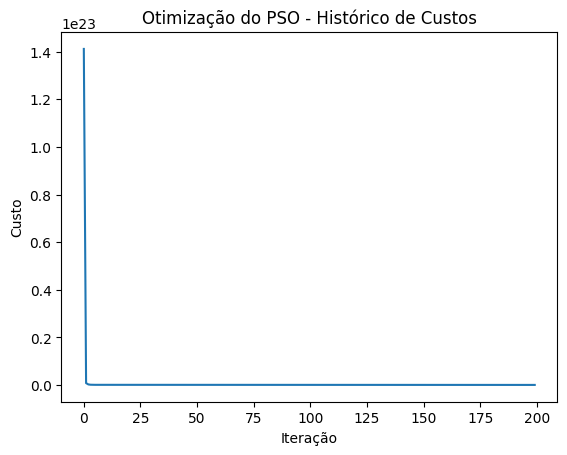

In [504]:
# Plotar gráfico de densidade da otimização

plt.figure()
plt.plot(optimizer.cost_history)
plt.xlabel('Iteração')
plt.ylabel('Custo')
plt.title('Otimização do PSO - Histórico de Custos')

plt.show()

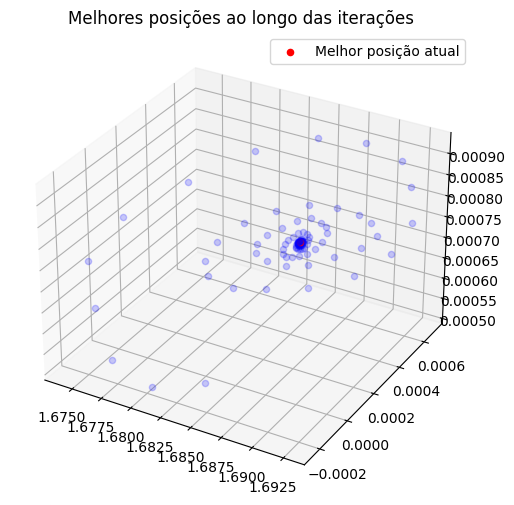

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
                              
Melhor custo: 1281764024526878.5
Melhor custo pessoal (pbest) de cada partícula: 1397928639365569.0


In [500]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], best_positions[i, 2], c='blue', alpha=0.2)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], best_positions[-1, 2], c='red', label='Melhor posição atual')

ax.set_title('Melhores posições ao longo das iterações')
ax.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")

print("Melhor custo:", best_cost)
print("Melhor custo pessoal (pbest) de cada partícula:", pbest_cost[0])